### Libraries and functions

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from BorutaShap import BorutaShap
from powershap  import PowerShap
import shapicant
from tqdm import tqdm
from SHAPEffects import FeatureSelector
import random
import shap
import os
os.environ['PYTHONHASHSEED'] = str(1234)
random.seed(1234)
np.random.seed(1234)
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'serif'

In [2]:
# Taken from PowerSHAP paper
def scores_calc_print(Y,Y_pred,print_bool):
    if len(Y_pred) > 1:
        R2_total = r2_score(Y,Y_pred)
    else:
        R2_total = -1
    RMSE_total = mean_squared_error(Y,Y_pred, squared=False)
    MAE_total = mean_absolute_error(Y,Y_pred)
    
    if print_bool:
        print(tabulate([[RMSE_total, MAE_total,R2_total]], ["RMSE","MAE","R²"], tablefmt="grid"))
    else:
        return {"R2":R2_total,"RMSE":RMSE_total,"MAE":MAE_total}

### Data

In [3]:
current_db = pd.read_csv(r"Data/datos_2019_v0.csv", index_col = 0)
current_db['fecha_completa'] = pd.to_datetime(current_db.fecha_completa)

Index_col = "fecha_completa"
target_col = "md_espana"

current_db = current_db.reset_index(drop=True)

In [4]:
current_db['hora'] = current_db.fecha_completa.dt.hour

In [5]:
list(current_db.columns)

['fecha',
 'hora',
 'pbf_hidraulica_ugh',
 'pbf_hidraulica_no_ugh',
 'pbf_nuclear',
 'pbf_ciclo_combinado',
 'pbf_eolica_terrestre',
 'pbf_solar_fotovoltaica',
 'pbf_solar_termica',
 'pbf_biomasa',
 'pbf_biogas',
 'potencia_indisponible_de_generacion_en_pbf',
 'capacidad_intercambio_francia_importacion',
 'capacidad_intercambio_francia_exportacion',
 'prevision_de_la_produccion_eolica',
 'generacion_prevista_solar_fotovoltaica',
 'generacion_prevista_solar_termica',
 'demanda_prevista',
 'demanda_programada',
 'md_espana',
 'mi1_espana',
 'mi2_espana',
 'mi3_espana',
 'asignacion_banda_de_regulacion_secundaria_a_subir',
 'asignacion_banda_de_regulacion_secundaria_a_bajar',
 'precio_banda_de_regulacion_secundaria',
 'asignacion_gestion_de_desvios_subir',
 'asignacion_gestion_de_desvios_bajar',
 'asignacion_regulacion_terciaria_subir',
 'precio_regulacion_terciaria_bajar',
 'precio_regulacion_terciaria_subir',
 'energia_utilizada_de_regulacion_secundaria_subir',
 'energia_utilizada_de_re

In [6]:
current_db

,fecha,hora,pbf_hidraulica_ugh,pbf_hidraulica_no_ugh,pbf_nuclear,pbf_ciclo_combinado,pbf_eolica_terrestre,pbf_solar_fotovoltaica,pbf_solar_termica,pbf_biomasa,...,q1_carbon,q3_carbon,min_carbon,max_carbon,curtosis_carbon,skew_carbon,variacion_intra1,variacion_intra2,variacion_intra3,variacion_temperatura
0,2019-01-09,1,626.1,539.4,7097.2,906.0,10504.9,7.1,42.0,315.6,...,81.901020,83.225000,80.95,85.15,-0.490645,0.409297,-1.00,1.74,-0.85,-2.39
1,2019-01-09,2,708.4,529.7,7098.1,565.0,10330.0,7.1,66.0,313.0,...,81.878061,83.225000,80.95,85.15,-0.485770,0.431687,0.00,1.25,-0.68,-2.42
2,2019-01-09,3,697.0,517.6,7097.2,554.0,10150.0,7.1,90.0,313.8,...,81.855102,83.225000,80.95,85.15,-0.482014,0.453319,0.30,0.50,-2.02,-2.78
3,2019-01-09,4,730.7,519.4,7098.1,404.0,9971.9,7.1,66.0,313.4,...,81.832143,83.225000,80.95,85.15,-0.479371,0.474127,0.99,1.00,-0.06,-3.39
4,2019-01-09,5,713.8,521.8,7098.1,404.0,9931.5,7.1,98.0,313.6,...,81.809184,83.225000,80.95,85.15,-0.477829,0.494049,0.50,0.00,1.50,-3.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31839,2022-08-27,20,919.0,362.7,6880.9,10269.2,4548.0,3779.4,1485.7,514.8,...,377.975000,401.138776,374.25,406.10,-1.672178,0.281929,-0.10,3.00,30.00,1.29
31840,2022-08-27,21,2322.0,383.1,6876.9,10344.0,4910.3,830.8,959.9,485.3,...,377.975000,401.430612,374.25,406.10,-1.682748,0.277390,0.00,3.98,11.70,1.57
31841,2022-08-27,22,2694.1,397.1,6881.9,10374.3,5154.6,53.2,520.6,485.3,...,377.975000,401.722449,374.25,406.10,-1.692465,0.273280,-1.86,2.00,7.99,1.79
31842,2022-08-27,23,2586.7,392.4,6903.9,10393.7,5236.6,7.7,463.8,487.0,...,377.975000,402.014286,374.25,406.10,-1.701361,0.269585,5.14,11.96,24.46,1.76


In [7]:
current_db['hueco_termico_real'] = current_db.demanda_real - current_db.generacion_treal_eolica - current_db.generacion_treal_solar_fotovoltaica
current_db['hueco_termico_casado'] = current_db.phfc_demanda_programada - current_db.phf3_eolica_terrestre - current_db.phf3_solar_fotovoltaica
current_db['hueco_termico_previsto_1d'] = current_db.prevision_diaria_d1_demanda - current_db.prevision_eolica_diaria_d1 - current_db.generacion_prevista_solar_fotovoltaica
current_db['hueco_termico_previsto_3h'] = current_db.prevision_h3_demanda - current_db.prevision_eolica_intradia_h3 - current_db.prevision_fotovoltaica_intradia_h3

In [8]:
current_db['hueco_termico_real_24'] = current_db['hueco_termico_real'].shift(24)
current_db['hueco_termico_real_48'] = current_db['hueco_termico_real'].shift(48)
current_db['hueco_termico_real_72'] = current_db['hueco_termico_real'].shift(72)
current_db['hueco_termico_real_168'] = current_db['hueco_termico_real'].shift(168)

current_db['hueco_termico_casado_24'] = current_db['hueco_termico_casado'].shift(24)
current_db['hueco_termico_casado_48'] = current_db['hueco_termico_casado'].shift(48)
current_db['hueco_termico_casado_72'] = current_db['hueco_termico_casado'].shift(72)
current_db['hueco_termico_casado_168'] = current_db['hueco_termico_casado'].shift(168)

current_db['hueco_termico_previsto_1d_24'] = current_db['hueco_termico_previsto_1d'].shift(24)
current_db['hueco_termico_previsto_1d_48'] = current_db['hueco_termico_previsto_1d'].shift(48)
current_db['hueco_termico_previsto_1d_72'] = current_db['hueco_termico_previsto_1d'].shift(72)
current_db['hueco_termico_previsto_1d_168'] = current_db['hueco_termico_previsto_1d'].shift(168)

current_db['hueco_termico_previsto_3h_24'] = current_db['hueco_termico_previsto_3h'].shift(24)
current_db['hueco_termico_previsto_3h_48'] = current_db['hueco_termico_previsto_3h'].shift(48)
current_db['hueco_termico_previsto_3h_72'] = current_db['hueco_termico_previsto_3h'].shift(72)
current_db['hueco_termico_previsto_3h_168'] = current_db['hueco_termico_previsto_3h'].shift(168)

In [9]:
current_db = current_db.dropna()

In [10]:
selected_columns = ['hora',
#  'capacidad_intercambio_francia_importacion',
#  'capacidad_intercambio_francia_exportacion',
 'prevision_de_la_produccion_eolica',
 'generacion_prevista_solar_fotovoltaica',
 'generacion_prevista_solar_termica',
#  'precio_de_los_desvios_medidos_a_subir',
#  'precio_de_los_desvios_medidos_a_bajar',
#  'intercambio_comercial_francia_importacion',
#  'intercambio_comercial_francia_exportacion',
#  'prevision_de_la_demanda_residual',
#  'potencia_disponible_nuclear',
 'prevision_eolica_diaria_d1',
 'prevision_renovable_diaria_d1',
 'prevision_diaria_d1_demanda',
#  'fecha_completa',
#  'pmd',
 'dia_semana',
#  'potencia_indisponible_de_generacion_en_pbf_24',
#  'potencia_indisponible_de_generacion_en_pbf_48',
#  'potencia_indisponible_de_generacion_en_pbf_72',
#  'potencia_indisponible_de_generacion_en_pbf_168',
#  'capacidad_intercambio_francia_importacion_24',
#  'capacidad_intercambio_francia_importacion_48',
#  'capacidad_intercambio_francia_importacion_72',
#  'capacidad_intercambio_francia_importacion_168',
#  'capacidad_intercambio_francia_exportacion_24',
#  'capacidad_intercambio_francia_exportacion_48',
#  'capacidad_intercambio_francia_exportacion_72',
#  'capacidad_intercambio_francia_exportacion_168',
 'prevision_de_la_produccion_eolica_24',
 'prevision_de_la_produccion_eolica_48',
 'prevision_de_la_produccion_eolica_72',
 'prevision_de_la_produccion_eolica_168',
 'generacion_prevista_solar_fotovoltaica_24',
 'generacion_prevista_solar_fotovoltaica_48',
 'generacion_prevista_solar_fotovoltaica_72',
 'generacion_prevista_solar_fotovoltaica_168',
 'generacion_prevista_solar_termica_24',
 'generacion_prevista_solar_termica_48',
 'generacion_prevista_solar_termica_72',
 'generacion_prevista_solar_termica_168',
#  'demanda_programada_24',
#  'demanda_programada_48',
#  'demanda_programada_72',
#  'demanda_programada_168',
 'md_espana_24',
 'md_espana_48',
 'md_espana_72',
 'md_espana_168',
 'mi1_espana_24',
 'mi1_espana_48',
 'mi1_espana_72',
 'mi1_espana_168',
 'mi2_espana_24',
 'mi2_espana_48',
 'mi2_espana_72',
 'mi2_espana_168',
 'mi3_espana_24',
 'mi3_espana_48',
 'mi3_espana_72',
 'mi3_espana_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_24',
 'asignacion_banda_de_regulacion_secundaria_a_subir_48',
 'asignacion_banda_de_regulacion_secundaria_a_subir_72',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_24',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_48',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_72',
 'asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'precio_banda_de_regulacion_secundaria_24',
 'precio_banda_de_regulacion_secundaria_48',
 'precio_banda_de_regulacion_secundaria_72',
 'precio_banda_de_regulacion_secundaria_168',
 'asignacion_gestion_de_desvios_subir_24',
 'asignacion_gestion_de_desvios_subir_48',
 'asignacion_gestion_de_desvios_subir_72',
 'asignacion_gestion_de_desvios_subir_168',
 'asignacion_gestion_de_desvios_bajar_24',
 'asignacion_gestion_de_desvios_bajar_48',
 'asignacion_gestion_de_desvios_bajar_72',
 'asignacion_gestion_de_desvios_bajar_168',
 'asignacion_regulacion_terciaria_subir_24',
 'asignacion_regulacion_terciaria_subir_48',
 'asignacion_regulacion_terciaria_subir_72',
 'asignacion_regulacion_terciaria_subir_168',
 'precio_regulacion_terciaria_bajar_24',
 'precio_regulacion_terciaria_bajar_48',
 'precio_regulacion_terciaria_bajar_72',
 'precio_regulacion_terciaria_bajar_168',
 'precio_regulacion_terciaria_subir_24',
 'precio_regulacion_terciaria_subir_48',
 'precio_regulacion_terciaria_subir_72',
 'precio_regulacion_terciaria_subir_168',
 'energia_utilizada_de_regulacion_secundaria_subir_24',
 'energia_utilizada_de_regulacion_secundaria_subir_48',
 'energia_utilizada_de_regulacion_secundaria_subir_72',
 'energia_utilizada_de_regulacion_secundaria_subir_168',
 'energia_utilizada_de_regulacion_secundaria_bajar_24',
 'energia_utilizada_de_regulacion_secundaria_bajar_48',
 'energia_utilizada_de_regulacion_secundaria_bajar_72',
 'energia_utilizada_de_regulacion_secundaria_bajar_168',
 'precio_de_utilizacion_de_secundaria_subir_24',
 'precio_de_utilizacion_de_secundaria_subir_48',
 'precio_de_utilizacion_de_secundaria_subir_72',
 'precio_de_utilizacion_de_secundaria_subir_168',
 'precio_de_utilizacion_de_secundaria_bajar_24',
 'precio_de_utilizacion_de_secundaria_bajar_48',
 'precio_de_utilizacion_de_secundaria_bajar_72',
 'precio_de_utilizacion_de_secundaria_bajar_168',
 'precio_de_los_desvios_medidos_a_subir_24',
 'precio_de_los_desvios_medidos_a_subir_48',
 'precio_de_los_desvios_medidos_a_subir_72',
 'precio_de_los_desvios_medidos_a_subir_168',
 'precio_de_los_desvios_medidos_a_bajar_24',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_de_los_desvios_medidos_a_bajar_72',
 'precio_de_los_desvios_medidos_a_bajar_168',
#  'demanda_real_24',
#  'demanda_real_48',
#  'demanda_real_72',
#  'demanda_real_168',
 'desvios_generacion_demanda_24',
 'desvios_generacion_demanda_48',
 'desvios_generacion_demanda_72',
 'desvios_generacion_demanda_168',
#  'energia_asignada_en_spot_intradiario_24',
#  'energia_asignada_en_spot_intradiario_48',
#  'energia_asignada_en_spot_intradiario_72',
#  'energia_asignada_en_spot_intradiario_168',
#  'intercambio_comercial_francia_importacion_24',
#  'intercambio_comercial_francia_importacion_48',
#  'intercambio_comercial_francia_importacion_72',
#  'intercambio_comercial_francia_importacion_168',
#  'intercambio_comercial_francia_exportacion_24',
#  'intercambio_comercial_francia_exportacion_48',
#  'intercambio_comercial_francia_exportacion_72',
#  'intercambio_comercial_francia_exportacion_168',
#  'prevision_de_la_demanda_residual_24',
#  'prevision_de_la_demanda_residual_48',
#  'prevision_de_la_demanda_residual_72',
#  'prevision_de_la_demanda_residual_168',
#  'pbf_demanda_24',
#  'pbf_demanda_48',
#  'pbf_demanda_72',
#  'pbf_demanda_168',
#  'pbf_generacion_24',
#  'pbf_generacion_48',
#  'pbf_generacion_72',
#  'pbf_generacion_168',
 'md_francia_24',
 'md_francia_48',
 'md_francia_72',
 'md_francia_168',
#  'volumen_mic_24',
#  'volumen_mic_48',
#  'volumen_mic_72',
#  'volumen_mic_168',
#  'potencia_disponible_nuclear_24',
#  'potencia_disponible_nuclear_48',
#  'potencia_disponible_nuclear_72',
#  'potencia_disponible_nuclear_168',
 'prevision_eolica_diaria_d1_24',
 'prevision_eolica_diaria_d1_48',
 'prevision_eolica_diaria_d1_72',
 'prevision_eolica_diaria_d1_168',
 'prevision_eolica_intradia_h3_24',
 'prevision_eolica_intradia_h3_48',
 'prevision_eolica_intradia_h3_72',
 'prevision_eolica_intradia_h3_168',
 'prevision_renovable_diaria_d1_24',
 'prevision_renovable_diaria_d1_48',
 'prevision_renovable_diaria_d1_72',
 'prevision_renovable_diaria_d1_168',
 'prevision_renovable_intradia_h3_24',
 'prevision_renovable_intradia_h3_48',
 'prevision_renovable_intradia_h3_72',
 'prevision_renovable_intradia_h3_168',
 'prevision_fotovoltaica_intradia_h3_24',
 'prevision_fotovoltaica_intradia_h3_48',
 'prevision_fotovoltaica_intradia_h3_72',
 'prevision_fotovoltaica_intradia_h3_168',
 'asignacion_regulacion_terciaria_bajar_24',
 'asignacion_regulacion_terciaria_bajar_48',
 'asignacion_regulacion_terciaria_bajar_72',
 'asignacion_regulacion_terciaria_bajar_168',
 'prevision_h3_demanda_24',
 'prevision_h3_demanda_48',
 'prevision_h3_demanda_72',
 'prevision_h3_demanda_168',
 'phfc_demanda_programada_24',
 'phfc_demanda_programada_48',
 'phfc_demanda_programada_72',
 'phfc_demanda_programada_168',
 'coste_asignacion_de_banda_secundaria_24',
 'coste_asignacion_de_banda_secundaria_48',
 'coste_asignacion_de_banda_secundaria_72',
 'coste_asignacion_de_banda_secundaria_168',
 'generacion_treal_eolica_24',
 'generacion_treal_eolica_48',
 'generacion_treal_eolica_72',
 'generacion_treal_eolica_168',
 'generacion_treal_solar_termica_24',
 'generacion_treal_solar_termica_48',
 'generacion_treal_solar_termica_72',
 'generacion_treal_solar_termica_168',
 'generacion_treal_solar_fotovoltaica_24',
 'generacion_treal_solar_fotovoltaica_48',
 'generacion_treal_solar_fotovoltaica_72',
 'generacion_treal_solar_fotovoltaica_168',
 'prevision_diaria_d1_demanda_24',
 'prevision_diaria_d1_demanda_48',
 'prevision_diaria_d1_demanda_72',
 'prevision_diaria_d1_demanda_168',
 'phf3_eolica_terrestre_24',
 'phf3_eolica_terrestre_48',
 'phf3_eolica_terrestre_72',
 'phf3_eolica_terrestre_168',
 'phf3_solar_fotovoltaica_24',
 'phf3_solar_fotovoltaica_48',
 'phf3_solar_fotovoltaica_72',
 'phf3_solar_fotovoltaica_168',
#  'pmd_24',
#  'pmd_48',
#  'pmd_72',
#  'pmd_168',
 'error_prevision_demanda_1d_24',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_72',
 'error_prevision_demanda_1d_168',
 'error_prevision_demanda_3h_24',
 'error_prevision_demanda_3h_48',
 'error_prevision_demanda_3h_72',
 'error_prevision_demanda_3h_168',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_48',
 'error_prevision_eolica_1d_72',
 'error_prevision_eolica_1d_168',
 'error_prevision_eolica_3h_24',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_72',
 'error_prevision_eolica_3h_168',
 'error_prevision_fotovoltaica_1d_24',
 'error_prevision_fotovoltaica_1d_48',
 'error_prevision_fotovoltaica_1d_72',
 'error_prevision_fotovoltaica_1d_168',
 'error_prevision_fotovoltaica_3h_24',
 'error_prevision_fotovoltaica_3h_48',
 'error_prevision_fotovoltaica_3h_72',
 'error_prevision_fotovoltaica_3h_168',
 'variacion_prevision_demanda_24',
 'variacion_prevision_demanda_48',
 'variacion_prevision_demanda_72',
 'variacion_prevision_demanda_168',
 'variacion_prevision_eolica_24',
 'variacion_prevision_eolica_48',
 'variacion_prevision_eolica_72',
 'variacion_prevision_eolica_168',
 'variacion_prevision_fotovoltaica_24',
 'variacion_prevision_fotovoltaica_48',
 'variacion_prevision_fotovoltaica_72',
 'variacion_prevision_fotovoltaica_168',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_demanda_1d_casacion_48',
 'error_prevision_demanda_1d_casacion_72',
 'error_prevision_demanda_1d_casacion_168',
 'error_prevision_demanda_3h_casacion_24',
 'error_prevision_demanda_3h_casacion_48',
 'error_prevision_demanda_3h_casacion_72',
 'error_prevision_demanda_3h_casacion_168',
 'error_prevision_eolica_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_1d_casacion_72',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_3h_casacion_24',
 'error_prevision_eolica_3h_casacion_48',
 'error_prevision_eolica_3h_casacion_72',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_fotovoltaica_1d_casacion_24',
 'error_prevision_fotovoltaica_1d_casacion_48',
 'error_prevision_fotovoltaica_1d_casacion_72',
 'error_prevision_fotovoltaica_1d_casacion_168',
 'error_prevision_fotovoltaica_3h_casacion_24',
 'error_prevision_fotovoltaica_3h_casacion_48',
 'error_prevision_fotovoltaica_3h_casacion_72',
 'error_prevision_fotovoltaica_3h_casacion_168',
 'precio_petroleo_24',
 'precio_petroleo_48',
 'precio_petroleo_72',
 'precio_petroleo_168',
 'precio_gas_24',
 'precio_gas_48',
 'precio_gas_72',
 'precio_gas_168',
 'precio_carbon_24',
 'precio_carbon_48',
 'precio_carbon_72',
 'precio_carbon_168',
 'precio_co2_24',
 'precio_co2_48',
 'precio_co2_72',
 'precio_co2_168',
#  'media_precios_subir',
#  'mediana_precios_subir',
#  'std_precios_subir',
#  'q1_precios_subir',
#  'q3_precios_subir',
#  'min_precios_subir',
#  'max_precios_subir',
#  'curtosis_precios_subir',
#  'skew_precios_subir',
#  'media_precios_bajar',
#  'mediana_precios_bajar',
#  'std_precios_bajar',
#  'q1_precios_bajar',
#  'q3_precios_bajar',
#  'min_precios_bajar',
#  'max_precios_bajar',
#  'curtosis_precios_bajar',
#  'skew_precios_bajar',
 'media_eolica',
 'mediana_eolica',
 'std_eolica',
 'q1_eolica',
 'q3_eolica',
 'min_eolica',
 'max_eolica',
 'curtosis_eolica',
 'skew_eolica',
 'media_fotovoltaica',
 'mediana_fotovoltaica',
 'std_fotovoltaica',
 'q1_fotovoltaica',
 'q3_fotovoltaica',
 'min_fotovoltaica',
 'max_fotovoltaica',
#  'curtosis_fotovoltaica',
#  'skew_fotovoltaica',
 'media_residual',
 'mediana_residual',
 'std_residual',
 'q1_residual',
 'q3_residual',
 'min_residual',
 'max_residual',
 'curtosis_residual',
 'skew_residual',
 'media_md_espana',
 'mediana_md_espana',
 'std_md_espana',
 'q1_md_espana',
 'q3_md_espana',
 'min_md_espana',
 'max_md_espana',
 'curtosis_md_espana',
 'skew_md_espana',
 'media_md_francia',
 'mediana_md_francia',
 'std_md_francia',
 'q1_md_francia',
 'q3_md_francia',
 'min_md_francia',
 'max_md_francia',
 'curtosis_md_francia',
 'skew_md_francia',
 'media_gas',
 'mediana_gas',
 'std_gas',
 'q1_gas',
 'q3_gas',
 'min_gas',
 'max_gas',
 'curtosis_gas',
 'skew_gas',
 'media_co2',
 'mediana_co2',
 'std_co2',
 'q1_co2',
 'q3_co2',
 'min_co2',
 'max_co2',
 'curtosis_co2',
 'skew_co2',
 'media_petroleo',
 'mediana_petroleo',
 'std_petroleo',
 'q3_petroleo',
 'min_petroleo',
 'max_petroleo',
 'curtosis_petroleo',
 'skew_petroleo',
 'media_carbon',
 'mediana_carbon',
 'std_carbon',
 'q1_carbon',
 'q3_carbon',
 'min_carbon',
 'max_carbon',
 'curtosis_carbon',
 'skew_carbon',
 'precio_petroleo',
 'precio_gas',
 'precio_carbon',
 'precio_co2',
 'hueco_termico_previsto_1d',
 'hueco_termico_real_24',
 'hueco_termico_casado_24',
 'hueco_termico_real_48',
 'hueco_termico_casado_48',
 'hueco_termico_real_72',
 'hueco_termico_casado_72',
 'hueco_termico_real_168',
 'hueco_termico_casado_168',
 'hueco_termico_previsto_1d_24',
 'hueco_termico_previsto_1d_48',
 'hueco_termico_previsto_1d_72',
 'hueco_termico_previsto_1d_168',
 'hueco_termico_previsto_3h_24',
 'hueco_termico_previsto_3h_48',
 'hueco_termico_previsto_3h_72',
 'hueco_termico_previsto_3h_168',]

In [11]:
current_db_train = current_db[(current_db.fecha_completa.dt.year == 2021) | ((current_db.fecha_completa.dt.year == 2022) & (current_db.fecha_completa.dt.month < 6))]
current_db_val = current_db[(current_db.fecha_completa.dt.year == 2022) & (current_db.fecha_completa.dt.month < 8) & (current_db.fecha_completa.dt.month >= 6)]
current_db_test = current_db[((current_db.fecha_completa.dt.year == 2022) & (current_db.fecha_completa.dt.month == 8))]

train_idx = current_db_train[Index_col].unique()
val_idx = current_db_val[Index_col].unique()
test_idx = current_db_test[Index_col].unique()

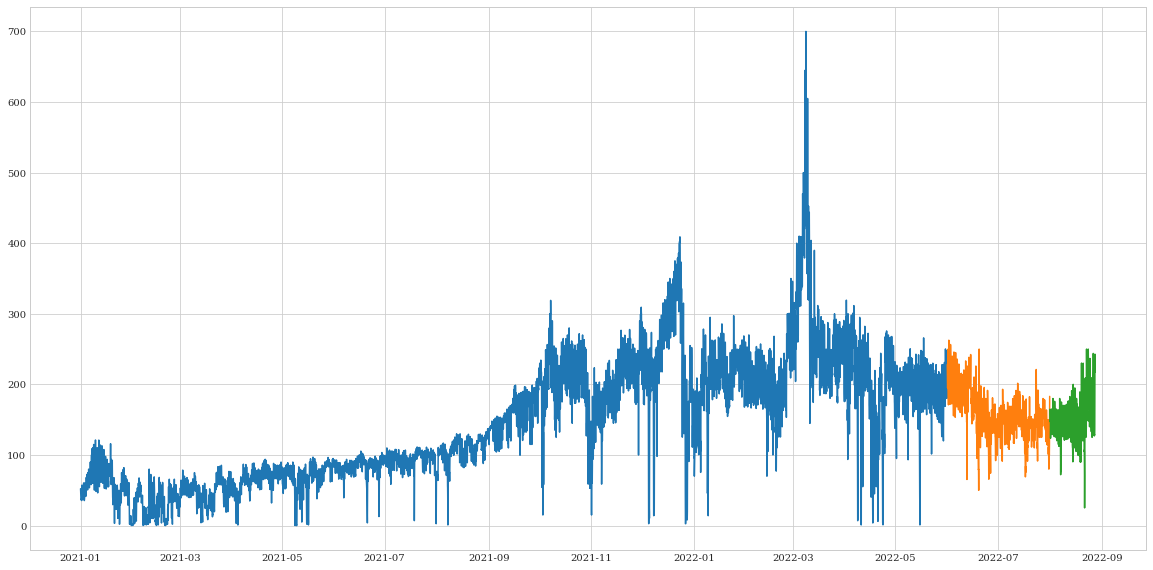

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.plot(current_db_train.fecha_completa, current_db_train.md_espana)
ax.plot(current_db_val.fecha_completa, current_db_val.md_espana)
ax.plot(current_db_test.fecha_completa, current_db_test.md_espana)

In [13]:
len(current_db_train), len(current_db_val), len(current_db_test)

(12382, 1464, 649)

In [14]:
len(selected_columns)

335

In [15]:
X_train = current_db_train[selected_columns]
y_train = current_db_train[target_col]

X_val = current_db_val[selected_columns]
y_val = current_db_val[target_col]

X_test = current_db_test[selected_columns]
y_test = current_db_test[target_col]

In [16]:
X_train_val = X_train.append(X_val)
y_train_val = y_train.append(y_val)

In [17]:
current_db_train_val = current_db_train.append(current_db_val)

In [18]:
seeds = np.random.randint(1, 999999, 50)

## SHAPEffects 0.75-0.25

In [19]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_075_025 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.25, 0.75)
selected_features_shapeffects_075_025 = sorted(list(selected_features_shapeffects_075_025))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
6 features have been removed
['asignacion_gestion_de_desvios_bajar_24', 'asignacion_gestion_de_desvios_bajar_48', 'asignacion_gestion_de_desvios_bajar_72', 'asignacion_gestion_de_desvios_bajar_168', 'asignacion_regulacion_terciaria_subir_48', 'variacion_prevision_fotovoltaica_72', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	24 features have been removed
	 ['generacion_prevista_solar_fotovoltaica', 'generacion_prevista_solar_fotovoltaica_48', 'generacion_prevista_solar_fotovoltaica_168', 'asignacion_banda_de_regulacion_secundaria_a_subir_24', 'asignacion_banda_de_regulacion_secundaria_a_subir_72', 'asignacion_banda_de_regulacion_secundaria_a_bajar_48', 'asignacion_gestion_de_desvios_subir_168', 'energia_utilizada_de_regulacion_secundaria_subir_24', 'energia_utilizada_de_regul


Iteration 24
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['media_gas']
	189 features left

Iteration 25
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_de_utilizacion_de_secundaria_subir_48']
	188 features left

Iteration 26
	Clasifying residuals
	Giving weights to features
	Selecting features
	3 features have been removed
	 ['prevision_de_la_produccion_eolica_24', 'asignacion_banda_de_regulacion_secundaria_a_bajar_72', 'error_prevision_fotovoltaica_1d_72']
	185 features left

Iteration 27
	Clasifying residuals
	Giving weights to features
	Selecting features
	4 features have been removed
	 ['md_espana_48', 'md_espana_72', 'phf3_solar_fotovoltaica_72', 'error_prevision_fotovoltaica_1d_casacion_168']
	181 features left

Iteration 28
	Clasifying residuals
	Giving weights to features
	Selecting features
	2 features have been removed
	 ['mi1_espana_48', 'skew_residual']


	Selecting features
	1 features have been removed
	 ['q3_md_francia']
	132 features left

Iteration 74
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_petroleo']
	131 features left

Iteration 75
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['generacion_treal_solar_termica_72']
	130 features left

Iteration 76
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_de_los_desvios_medidos_a_bajar_24']
	129 features left

Iteration 77
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['std_co2']
	128 features left

Iteration 78
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['std_gas']
	127 features left

Iteration 79
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been rem


Iteration 125
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['generacion_treal_solar_termica_168']
	80 features left

Iteration 126
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['hueco_termico_casado_168']
	79 features left

Iteration 127
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_demanda_1d_72']
	78 features left

Iteration 128
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['std_md_francia']
	77 features left

Iteration 129
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['curtosis_petroleo']
	76 features left

Iteration 130
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_eolica_1d_24']
	75 features left

Iteration 131


Iteration 174
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['prevision_eolica_intradia_h3_48']
	31 features left

Iteration 175
	Clasifying residuals
	Giving weights to features
	Selecting features
	0 features have been removed
	31 features left
31 features have been selected out of 336


In [20]:
feat_sel.best_mae

18.689990198908994

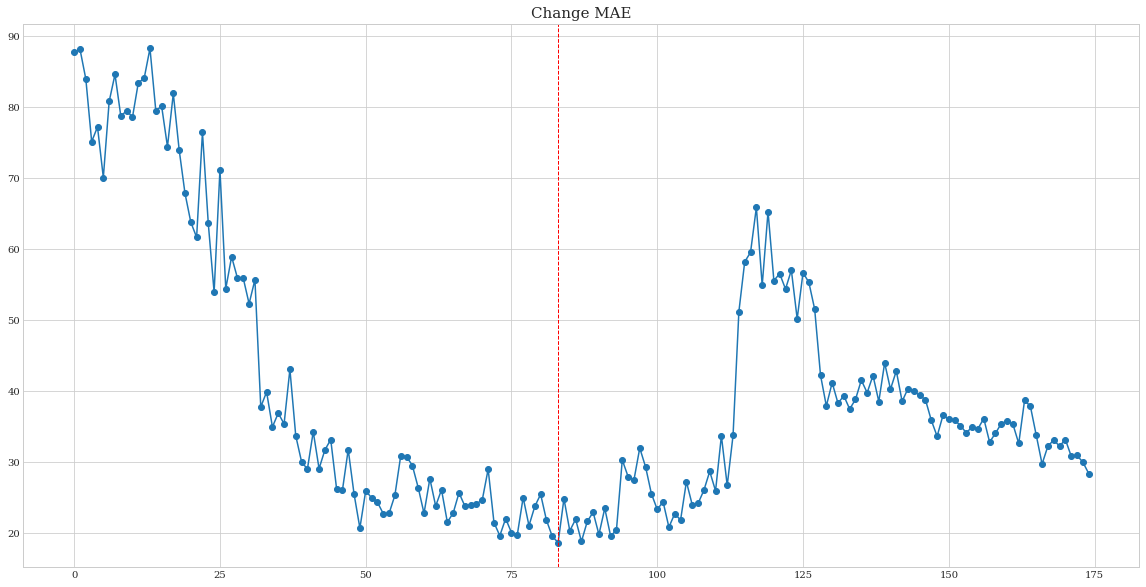

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("Change MAE")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [22]:
selected_features_shapeffects_075_025

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'coste_asignacion_de_banda_secundaria_72',
 'curtosis_carbon',
 'curtosis_co2',
 'curtosis_eolica',
 'curtosis_gas',
 'curtosis_petroleo',
 'curtosis_residual',
 'desvios_generacion_demanda_72',
 'dia_semana',
 'error_prevision_demanda_1d_24',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_72',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_demanda_1d_casacion_48',
 'error_prevision_demanda_1d_casacion_72',
 'error_prevision_demanda_3h_168',
 'error_prevision_demanda_3h_casacion_48',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_48',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_1d_casacion_72',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_eolica_3h_casacion_48',
 'error_pre

In [23]:
dict_results_shapeffects_075_025 = {'rmse':[], 'mae':[], 'r2':[]}

In [24]:
X_test_shapeffects = X_test[selected_features_shapeffects_075_025]
X_train_shapeffects= X_train[selected_features_shapeffects_075_025]
X_val_shapeffects = X_val[selected_features_shapeffects_075_025]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_075_025["r2"].append(test_results["R2"])
    dict_results_shapeffects_075_025["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_075_025["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [25]:
results_shapeffects_075_025_df = pd.DataFrame(dict_results_shapeffects_075_025)
mean_shapeffects_075_025_test = results_shapeffects_075_025_df.mean()
std_shapeffects_075_025_test = results_shapeffects_075_025_df.std()
max_shapeffects_075_025_test = results_shapeffects_075_025_df.max()
min_shapeffects_075_025_test = results_shapeffects_075_025_df.min()

In [26]:
mean_shapeffects_075_025_test, std_shapeffects_075_025_test, max_shapeffects_075_025_test, min_shapeffects_075_025_test

(rmse    23.356830
 mae     18.278111
 r2       0.428870
 dtype: float64,
 rmse    1.134956
 mae     0.993385
 r2      0.055880
 dtype: float64,
 rmse    26.479329
 mae     20.274958
 r2       0.530926
 dtype: float64,
 rmse    21.191842
 mae     16.471093
 r2       0.267652
 dtype: float64)

## SHAPEffects 0.8-0.2

In [27]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_08_02 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.2, 0.8)
selected_features_shapeffects_08_02 = sorted(list(selected_features_shapeffects_08_02))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
0 features have been removed

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selecting features
	25 features have been removed
	 ['generacion_prevista_solar_fotovoltaica_48', 'generacion_prevista_solar_fotovoltaica_72', 'mi2_espana_72', 'asignacion_banda_de_regulacion_secundaria_a_subir_48', 'asignacion_banda_de_regulacion_secundaria_a_subir_72', 'asignacion_banda_de_regulacion_secundaria_a_bajar_24', 'asignacion_banda_de_regulacion_secundaria_a_bajar_48', 'asignacion_gestion_de_desvios_subir_24', 'asignacion_gestion_de_desvios_subir_168', 'asignacion_gestion_de_desvios_bajar_48', 'asignacion_gestion_de_desvios_bajar_72', 'precio_de_los_desvios_medidos_a_subir_48', 'precio_de_los_desvios_medidos_a_subir_168', 'prevision_eolica_diaria_d1_24', 'prevision_fotovoltaica_intradia_h3_24', 'prevision_h3_demanda_24', 'phfc_d

	Clasifying residuals
	Giving weights to features
	Selecting features
	3 features have been removed
	 ['error_prevision_fotovoltaica_1d_48', 'mediana_co2', 'q1_co2']
	191 features left

Iteration 26
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['desvios_generacion_demanda_168']
	190 features left

Iteration 27
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['media_md_espana']
	189 features left

Iteration 28
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['prevision_renovable_intradia_h3_168']
	188 features left

Iteration 29
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_gas_48']
	187 features left

Iteration 30
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['min_gas']
	186 features left

Iteration 31
	


Iteration 74
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['q1_carbon']
	133 features left

Iteration 75
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_co2_72']
	132 features left

Iteration 76
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['coste_asignacion_de_banda_secundaria_24']
	131 features left

Iteration 77
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['q3_co2']
	130 features left

Iteration 78
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mediana_md_espana']
	129 features left

Iteration 79
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['media_petroleo']
	128 features left

Iteration 80
	Clasifying residuals
	Giving weights to feature


Iteration 125
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['q3_residual']
	82 features left

Iteration 126
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['skew_co2']
	81 features left

Iteration 127
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_demanda_1d_casacion_24']
	80 features left

Iteration 128
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['variacion_prevision_demanda_24']
	79 features left

Iteration 129
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_eolica_1d_casacion_72']
	78 features left

Iteration 130
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_demanda_1d_72']
	77 features left

Iterat

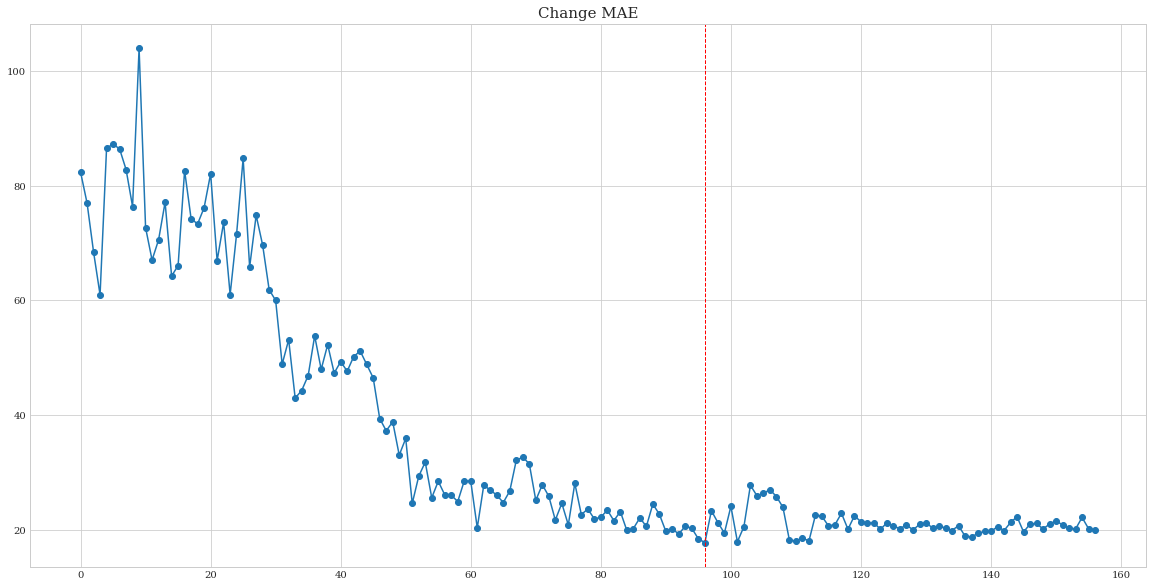

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("Change MAE")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [29]:
selected_features_shapeffects_08_02

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'curtosis_carbon',
 'curtosis_co2',
 'curtosis_eolica',
 'curtosis_gas',
 'curtosis_petroleo',
 'desvios_generacion_demanda_72',
 'dia_semana',
 'error_prevision_demanda_1d_24',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_72',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_demanda_1d_casacion_48',
 'error_prevision_demanda_1d_casacion_72',
 'error_prevision_demanda_3h_casacion_24',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_1d_casacion_72',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_72',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_eolica_3h_casacion_48',
 'error_prevision_eolica_3h_casacion_72',
 'error_prevision_fotovoltaica_1d_168',
 'error_prevision_fotovoltaica_3h_24',
 'error_prevision_fotovoltaica_3h_casacion_24',
 'error_prevision_fotovoltaica_3h_casacion_

In [30]:
dict_results_shapeffects_08_02 = {'rmse':[], 'mae':[], 'r2':[]}

In [31]:
X_test_shapeffects = X_test[selected_features_shapeffects_08_02]
X_train_shapeffects= X_train[selected_features_shapeffects_08_02]
X_val_shapeffects = X_val[selected_features_shapeffects_08_02]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_08_02["r2"].append(test_results["R2"])
    dict_results_shapeffects_08_02["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_08_02["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [32]:
results_shapeffects_08_02_df = pd.DataFrame(dict_results_shapeffects_08_02)
mean_shapeffects_08_02_test = results_shapeffects_08_02_df.mean()
std_shapeffects_08_02_test = results_shapeffects_08_02_df.std()
max_shapeffects_08_02_test = results_shapeffects_08_02_df.max()
min_shapeffects_08_02_test = results_shapeffects_08_02_df.min()

In [33]:
mean_shapeffects_08_02_test, std_shapeffects_08_02_test, max_shapeffects_08_02_test, min_shapeffects_08_02_test

(rmse    21.501143
 mae     16.973886
 r2       0.516379
 dtype: float64,
 rmse    0.858855
 mae     0.774449
 r2      0.038943
 dtype: float64,
 rmse    23.364246
 mae     19.323168
 r2       0.581536
 dtype: float64,
 rmse    20.015994
 mae     15.766051
 r2       0.429826
 dtype: float64)

## SHAPEffects 0.85-0.15

In [34]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_085_015 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.15, 0.85)
selected_features_shapeffects_085_015 = sorted(list(selected_features_shapeffects_085_015))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
88 features have been removed
['generacion_prevista_solar_fotovoltaica_24', 'generacion_prevista_solar_fotovoltaica_72', 'generacion_prevista_solar_fotovoltaica_168', 'generacion_prevista_solar_termica_48', 'asignacion_banda_de_regulacion_secundaria_a_subir_48', 'asignacion_banda_de_regulacion_secundaria_a_subir_72', 'asignacion_banda_de_regulacion_secundaria_a_bajar_24', 'asignacion_banda_de_regulacion_secundaria_a_bajar_48', 'asignacion_banda_de_regulacion_secundaria_a_bajar_72', 'asignacion_gestion_de_desvios_subir_24', 'asignacion_gestion_de_desvios_subir_72', 'asignacion_gestion_de_desvios_subir_168', 'asignacion_gestion_de_desvios_bajar_24', 'asignacion_gestion_de_desvios_bajar_48', 'asignacion_gestion_de_desvios_bajar_72', 'asignacion_gestion_de_desvios_bajar_168', 'asignacion_regulacion_terciaria_subir_24', 'asignacion_regulacion_terciaria_subir_48', 'asignacion_reg


Iteration 22
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['media_gas']
	183 features left

Iteration 23
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['generacion_prevista_solar_termica_72']
	182 features left

Iteration 24
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['max_residual']
	181 features left

Iteration 25
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['prevision_de_la_produccion_eolica_24']
	180 features left

Iteration 26
	Clasifying residuals
	Giving weights to features
	Selecting features
	2 features have been removed
	 ['prevision_h3_demanda_168', 'phf3_solar_fotovoltaica_168']
	178 features left

Iteration 27
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_gas_72']
	177 features left


Iteration 72
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_gas_168']
	126 features left

Iteration 73
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['std_carbon']
	125 features left

Iteration 74
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['phf3_solar_fotovoltaica_24']
	124 features left

Iteration 75
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mi2_espana_24']
	123 features left

Iteration 76
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['prevision_renovable_diaria_d1_24']
	122 features left

Iteration 77
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mi3_espana_24']
	121 features left

Iteration 78
	Clasifying residuals
	Giving weights 


Iteration 123
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['coste_asignacion_de_banda_secundaria_24']
	75 features left

Iteration 124
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['hueco_termico_previsto_1d_24']
	74 features left

Iteration 125
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_banda_de_regulacion_secundaria_168']
	73 features left

Iteration 126
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['generacion_treal_solar_fotovoltaica_48']
	72 features left

Iteration 127
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_eolica_1d_casacion_72']
	71 features left

Iteration 128
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 


Iteration 172
	Clasifying residuals
	Giving weights to features
	Selecting features
	0 features have been removed
	27 features left
27 features have been selected out of 336


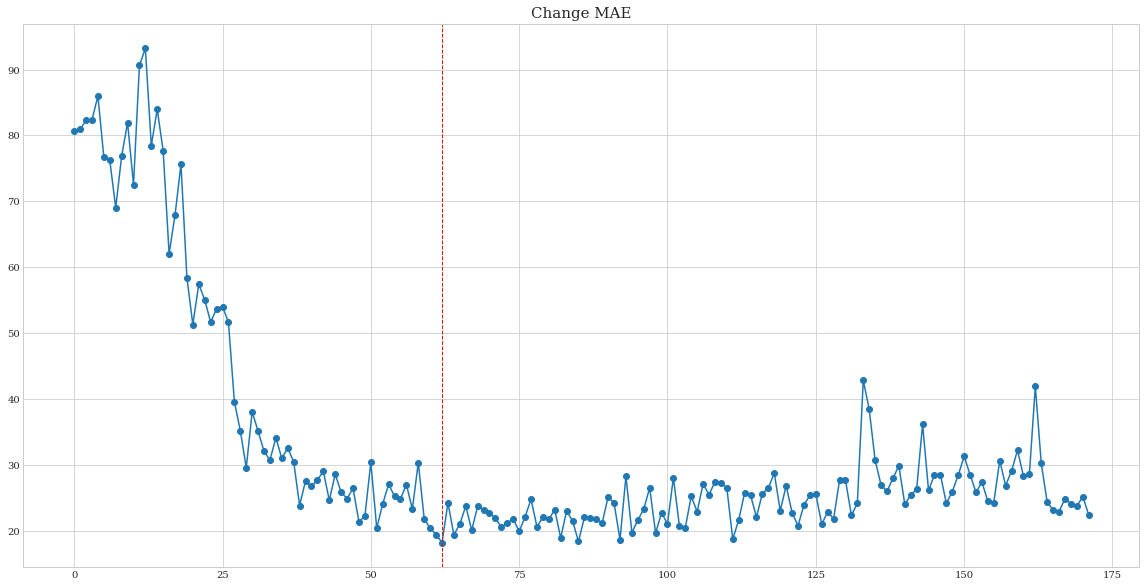

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("Change MAE")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [36]:
selected_features_shapeffects_085_015

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'coste_asignacion_de_banda_secundaria_24',
 'curtosis_carbon',
 'curtosis_co2',
 'curtosis_eolica',
 'curtosis_gas',
 'curtosis_petroleo',
 'curtosis_residual',
 'desvios_generacion_demanda_72',
 'dia_semana',
 'error_prevision_demanda_1d_24',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_72',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_demanda_1d_casacion_48',
 'error_prevision_demanda_1d_casacion_72',
 'error_prevision_demanda_3h_168',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_48',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_1d_casacion_72',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_eolica_3h_casacion_48',
 'error_prevision_eolica_3h_casacion_72',
 'error_prevision_fotovoltaica_3h_168',
 'error_previs

In [37]:
dict_results_shapeffects_085_015 = {'rmse':[], 'mae':[], 'r2':[]}

In [38]:
X_test_shapeffects = X_test[selected_features_shapeffects_085_015]
X_train_shapeffects= X_train[selected_features_shapeffects_085_015]
X_val_shapeffects = X_val[selected_features_shapeffects_085_015]
for iteration in range(50):
    while True:
        try:
            print(iteration)
            model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
            model.fit(
                X_train_shapeffects, y_train,
                eval_set=(X_val_shapeffects, y_val),
                verbose = 0,
                plot=False
            );

            test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)

            dict_results_shapeffects_085_015["r2"].append(test_results["R2"])
            dict_results_shapeffects_085_015["rmse"].append(test_results["RMSE"])
            dict_results_shapeffects_085_015["mae"].append(test_results["MAE"])
        except Exception as e:
            print("There was an error with the CatBoost")
            print(e)
            continue
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [39]:
results_shapeffects_085_015_df = pd.DataFrame(dict_results_shapeffects_085_015)
mean_shapeffects_085_015_test = results_shapeffects_085_015_df.mean()
std_shapeffects_085_015_test = results_shapeffects_085_015_df.std()
max_shapeffects_085_015_test = results_shapeffects_085_015_df.max()
min_shapeffects_085_015_test = results_shapeffects_085_015_df.min()

In [40]:
mean_shapeffects_085_015_test, std_shapeffects_085_015_test, max_shapeffects_085_015_test, min_shapeffects_085_015_test

(rmse    23.780314
 mae     19.007845
 r2       0.405921
 dtype: float64,
 rmse    1.827202
 mae     1.687475
 r2      0.093238
 dtype: float64,
 rmse    28.833952
 mae     23.878394
 r2       0.539492
 dtype: float64,
 rmse    20.997468
 mae     16.395559
 r2       0.131616
 dtype: float64)

## SHAPEffects 0.9-0.1

In [41]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_09_01 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.1, 0.9)
selected_features_shapeffects_09_01 = sorted(list(selected_features_shapeffects_09_01))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
16 features have been removed
['asignacion_banda_de_regulacion_secundaria_a_subir_72', 'asignacion_gestion_de_desvios_subir_168', 'asignacion_gestion_de_desvios_bajar_24', 'asignacion_gestion_de_desvios_bajar_48', 'asignacion_gestion_de_desvios_bajar_72', 'asignacion_gestion_de_desvios_bajar_168', 'asignacion_regulacion_terciaria_subir_24', 'asignacion_regulacion_terciaria_subir_48', 'asignacion_regulacion_terciaria_subir_72', 'energia_utilizada_de_regulacion_secundaria_subir_72', 'energia_utilizada_de_regulacion_secundaria_subir_168', 'asignacion_regulacion_terciaria_bajar_24', 'asignacion_regulacion_terciaria_bajar_48', 'asignacion_regulacion_terciaria_bajar_168', 'variacion_prevision_fotovoltaica_48', 'variacion_prevision_fotovoltaica_72', 'RandomVariable']

Starting core module
--------------------

Iteration 1
	Clasifying residuals
	Giving weights to features
	Selectin


Iteration 23
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_gas']
	187 features left

Iteration 24
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_gas_48']
	186 features left

Iteration 25
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['min_gas']
	185 features left

Iteration 26
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['asignacion_banda_de_regulacion_secundaria_a_bajar_48']
	184 features left

Iteration 27
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['hueco_termico_previsto_1d']
	183 features left

Iteration 28
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_fotovoltaica_1d_168']
	182 features left

Iteration 29
	Cla

	Selecting features
	1 features have been removed
	 ['mi2_espana_168']
	135 features left

Iteration 75
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_carbon_24']
	134 features left

Iteration 76
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['generacion_prevista_solar_termica_72']
	133 features left

Iteration 77
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_banda_de_regulacion_secundaria_168']
	132 features left

Iteration 78
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['error_prevision_eolica_3h_casacion_24']
	131 features left

Iteration 79
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['skew_md_espana']
	130 features left

Iteration 80
	Clasifying residuals
	Giving weights to features
	S


Iteration 124
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_petroleo_168']
	85 features left

Iteration 125
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['q3_co2']
	84 features left

Iteration 126
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_regulacion_terciaria_bajar_48']
	83 features left

Iteration 127
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['mi2_espana_24']
	82 features left

Iteration 128
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['curtosis_eolica']
	81 features left

Iteration 129
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['variacion_prevision_eolica_24']
	80 features left

Iteration 130
	Clasifying residuals
	Givi

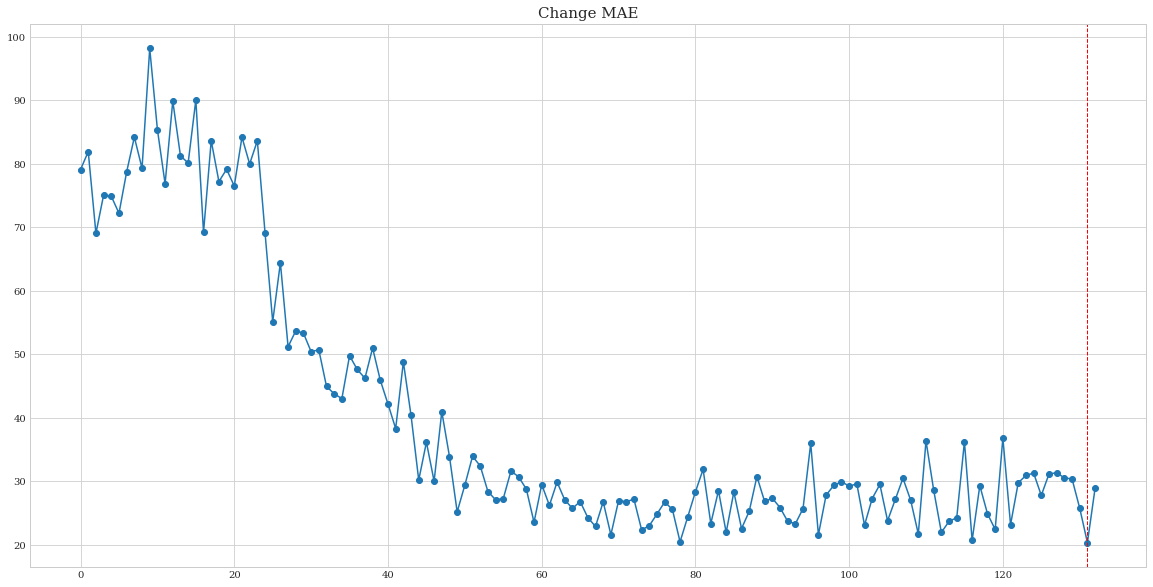

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("Change MAE")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [43]:
selected_features_shapeffects_09_01

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'coste_asignacion_de_banda_secundaria_168',
 'coste_asignacion_de_banda_secundaria_24',
 'coste_asignacion_de_banda_secundaria_72',
 'dia_semana',
 'error_prevision_demanda_1d_24',
 'error_prevision_demanda_3h_168',
 'error_prevision_demanda_3h_casacion_72',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_48',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_eolica_3h_casacion_48',
 'error_prevision_eolica_3h_casacion_72',
 'error_prevision_fotovoltaica_3h_48',
 'error_prevision_fotovoltaica_3h_casacion_48',
 'error_prevision_fotovoltaica_3h_casacion_72',
 'generacion_prevista_solar_termica',
 'generacion_prevista_solar_termica_168',
 'generacion_treal_eolica_24',
 'generacion_treal_solar_fotovoltaica_168',
 'generacion_treal_sola

In [44]:
dict_results_shapeffects_09_01 = {'rmse':[], 'mae':[], 'r2':[]}

In [45]:
X_test_shapeffects = X_test[selected_features_shapeffects_09_01]
X_train_shapeffects= X_train[selected_features_shapeffects_09_01]
X_val_shapeffects = X_val[selected_features_shapeffects_09_01]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_09_01["r2"].append(test_results["R2"])
    dict_results_shapeffects_09_01["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_09_01["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [46]:
results_shapeffects_09_01_df = pd.DataFrame(dict_results_shapeffects_09_01)
mean_shapeffects_09_01_test = results_shapeffects_09_01_df.mean()
std_shapeffects_09_01_test = results_shapeffects_09_01_df.std()
max_shapeffects_09_01_test = results_shapeffects_09_01_df.max()
min_shapeffects_09_01_test = results_shapeffects_09_01_df.min()

In [47]:
mean_shapeffects_09_01_test, std_shapeffects_09_01_test, max_shapeffects_09_01_test, min_shapeffects_09_01_test

(rmse    25.774215
 mae     20.566119
 r2       0.301624
 dtype: float64,
 rmse    2.099537
 mae     1.882467
 r2      0.117015
 dtype: float64,
 rmse    33.505100
 mae     27.719527
 r2       0.516872
 dtype: float64,
 rmse    21.506962
 mae     16.691684
 r2      -0.172534
 dtype: float64)

## SHAPEffects 0.95-0.05

In [48]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)
feat_sel = FeatureSelector()
selected_features_shapeffects_095_005 = feat_sel.fit(X_train, y_train, X_val, y_val, model, 30, 0.05, 0.95)
selected_features_shapeffects_095_005 = sorted(list(selected_features_shapeffects_095_005))

Preprocessing
-------------

Introducing a random variable
Calculating Shapley values
Removing the first features
59 features have been removed
['generacion_prevista_solar_fotovoltaica_24', 'generacion_prevista_solar_fotovoltaica_72', 'generacion_prevista_solar_fotovoltaica_168', 'generacion_prevista_solar_termica_48', 'asignacion_banda_de_regulacion_secundaria_a_subir_48', 'asignacion_banda_de_regulacion_secundaria_a_subir_72', 'asignacion_gestion_de_desvios_subir_24', 'asignacion_gestion_de_desvios_subir_168', 'asignacion_gestion_de_desvios_bajar_24', 'asignacion_gestion_de_desvios_bajar_48', 'asignacion_gestion_de_desvios_bajar_72', 'asignacion_gestion_de_desvios_bajar_168', 'asignacion_regulacion_terciaria_subir_24', 'asignacion_regulacion_terciaria_subir_48', 'asignacion_regulacion_terciaria_subir_72', 'asignacion_regulacion_terciaria_subir_168', 'energia_utilizada_de_regulacion_secundaria_subir_24', 'energia_utilizada_de_regulacion_secundaria_subir_48', 'energia_utilizada_de_regu


Iteration 23
	Clasifying residuals
	Giving weights to features
	Selecting features
	3 features have been removed
	 ['md_francia_72', 'prevision_eolica_intradia_h3_168', 'q3_carbon']
	187 features left

Iteration 24
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['phf3_solar_fotovoltaica_72']
	186 features left

Iteration 25
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['dia_semana']
	185 features left

Iteration 26
	Clasifying residuals
	Giving weights to features
	Selecting features
	3 features have been removed
	 ['phf3_eolica_terrestre_48', 'error_prevision_fotovoltaica_3h_48', 'min_md_francia']
	182 features left

Iteration 27
	Clasifying residuals
	Giving weights to features
	Selecting features
	2 features have been removed
	 ['phf3_solar_fotovoltaica_168', 'curtosis_md_francia']
	180 features left

Iteration 28
	Clasifying residuals
	Giving weights to features
	Selecti


Iteration 73
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['prevision_renovable_diaria_d1_24']
	133 features left

Iteration 74
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['precio_banda_de_regulacion_secundaria_24']
	132 features left

Iteration 75
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['prevision_renovable_intradia_h3_72']
	131 features left

Iteration 76
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['std_petroleo']
	130 features left

Iteration 77
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['std_co2']
	129 features left

Iteration 78
	Clasifying residuals
	Giving weights to features
	Selecting features
	1 features have been removed
	 ['md_espana_48']
	128 features left

Iteration 79
	Clasifyi

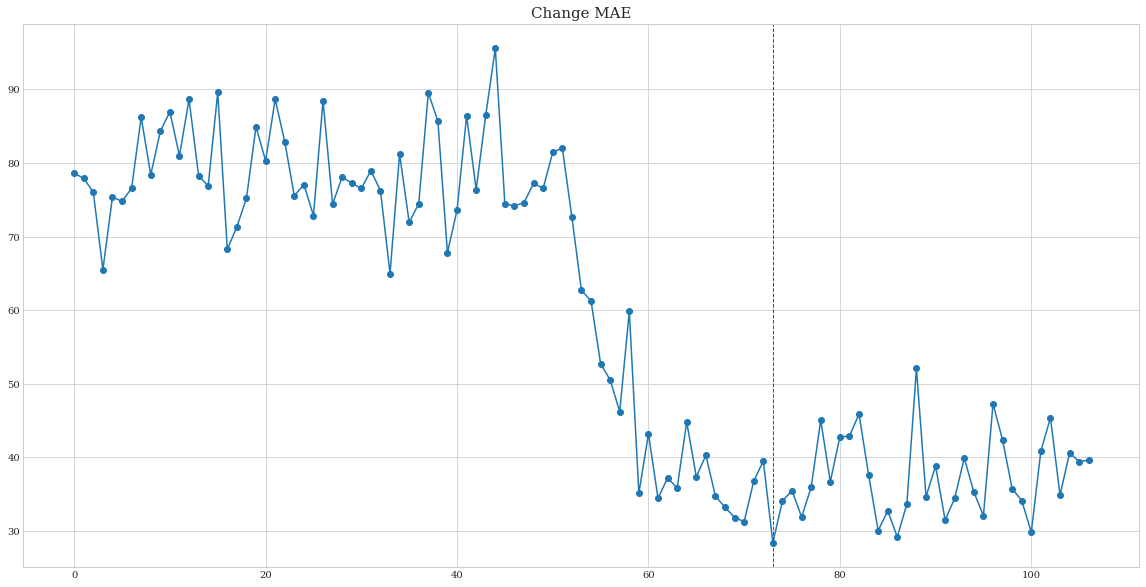

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(range(len(feat_sel.maes)), feat_sel.maes.keys(), '-o')
ax.title.set_text("Change MAE")
ax.title.set_size(15)
plt.axvline(np.argmin(list(feat_sel.maes.keys())), color='red', linestyle='dashed', linewidth=1)

In [50]:
selected_features_shapeffects_095_005

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'asignacion_banda_de_regulacion_secundaria_a_subir_168',
 'coste_asignacion_de_banda_secundaria_24',
 'curtosis_carbon',
 'curtosis_co2',
 'curtosis_eolica',
 'curtosis_gas',
 'curtosis_petroleo',
 'desvios_generacion_demanda_168',
 'error_prevision_demanda_1d_48',
 'error_prevision_demanda_1d_72',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_demanda_1d_casacion_48',
 'error_prevision_demanda_1d_casacion_72',
 'error_prevision_demanda_3h_168',
 'error_prevision_demanda_3h_casacion_24',
 'error_prevision_eolica_1d_24',
 'error_prevision_eolica_1d_48',
 'error_prevision_eolica_1d_casacion_168',
 'error_prevision_eolica_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_48',
 'error_prevision_eolica_1d_casacion_72',
 'error_prevision_eolica_3h_48',
 'error_prevision_eolica_3h_casacion_168',
 'error_prevision_eolica_3h_casacion_24',
 'error_prevision_eolica_3h_casacion_48',
 'error_prevision_eolica_3h_casacion_72

In [51]:
dict_results_shapeffects_095_005 = {'rmse':[], 'mae':[], 'r2':[]}

In [52]:
X_test_shapeffects = X_test[selected_features_shapeffects_095_005]
X_train_shapeffects= X_train[selected_features_shapeffects_095_005]
X_val_shapeffects = X_val[selected_features_shapeffects_095_005]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapeffects, y_train,
        eval_set=(X_val_shapeffects, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapeffects), print_bool=False)
    
    dict_results_shapeffects_095_005["r2"].append(test_results["R2"])
    dict_results_shapeffects_095_005["rmse"].append(test_results["RMSE"])
    dict_results_shapeffects_095_005["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [53]:
results_shapeffects_095_005_df = pd.DataFrame(dict_results_shapeffects_095_005)
mean_shapeffects_095_005_test = results_shapeffects_095_005_df.mean()
std_shapeffects_095_005_test = results_shapeffects_095_005_df.std()
max_shapeffects_095_005_test = results_shapeffects_095_005_df.max()
min_shapeffects_095_005_test = results_shapeffects_095_005_df.min()

In [54]:
mean_shapeffects_095_005_test, std_shapeffects_095_005_test, max_shapeffects_095_005_test, min_shapeffects_095_005_test

(rmse    27.188394
 mae     20.992217
 r2       0.225024
 dtype: float64,
 rmse    1.677725
 mae     1.502980
 r2      0.096666
 dtype: float64,
 rmse    31.340624
 mae     24.206272
 r2       0.404650
 dtype: float64,
 rmse    23.874508
 mae     18.503366
 r2      -0.025933
 dtype: float64)

## PowerSHAP

In [55]:
selector = PowerShap(
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123),
    power_iterations=10,automatic=True, limit_automatic=10,verbose=True,target_col=target_col,index_col=Index_col,
)
selector.fit(current_db_train_val[list(selected_columns)], current_db_train_val[target_col])
# 42.6 segundos

Starting powershap
Automatic mode enabled: Finding the minimal required powershap iterations for significance of 0.01.



Automatic mode: powershap requires 88  iterations; The extra required iterations exceed the limit_automatic  threshold. Powershap will add  10 powershap iterations and  re-evaluate.



Automatic mode: powershap requires 81  iterations; The extra required iterations exceed the limit_automatic  threshold. Powershap will add  10 powershap iterations and  re-evaluate.



Automatic mode: powershap requires 50  iterations; The extra required iterations exceed the limit_automatic  threshold. Powershap will add  10 powershap iterations and  re-evaluate.



Done!


PowerShap(model=<catboost.core.CatBoostRegressor object at 0x000001FB24D96E20>,
          verbose=True)

In [56]:
t = selector._processed_shaps_df
selected_features_powershap = t[(t.p_value<0.01)].index.values
selected_features_powershap

array(['hueco_termico_previsto_1d', 'precio_gas_24', 'mi2_espana_24',
       'precio_gas', 'precio_regulacion_terciaria_subir_24',
       'mi1_espana_24', 'mi3_espana_24', 'md_espana_24', 'precio_gas_48',
       'q3_md_espana', 'precio_co2_24', 'max_gas', 'media_gas',
       'precio_co2_48', 'precio_de_los_desvios_medidos_a_bajar_24',
       'min_gas', 'q1_md_espana', 'prevision_renovable_diaria_d1',
       'mi3_espana_168', 'precio_regulacion_terciaria_subir_72',
       'precio_de_utilizacion_de_secundaria_bajar_24', 'dia_semana',
       'asignacion_banda_de_regulacion_secundaria_a_bajar_168',
       'mediana_gas', 'precio_carbon_48', 'precio_carbon',
       'prevision_eolica_diaria_d1', 'precio_gas_168', 'precio_carbon_24',
       'md_francia_24', 'std_petroleo',
       'precio_regulacion_terciaria_bajar_24', 'mi3_espana_72',
       'prevision_de_la_produccion_eolica', 'precio_co2', 'std_gas',
       'max_co2', 'precio_regulacion_terciaria_subir_48', 'precio_co2_72',
       'precio_g

In [57]:
selected_features_powershap = sorted(selected_features_powershap)

In [19]:
selected_features_powershap = sorted(['hueco_termico_previsto_1d', 'precio_gas_24', 'mi2_espana_24',
       'precio_gas', 'precio_regulacion_terciaria_subir_24',
       'mi1_espana_24', 'mi3_espana_24', 'md_espana_24', 'precio_gas_48',
       'q3_md_espana', 'precio_co2_24', 'max_gas', 'media_gas',
       'precio_co2_48', 'precio_de_los_desvios_medidos_a_bajar_24',
       'min_gas', 'q1_md_espana', 'prevision_renovable_diaria_d1',
       'mi3_espana_168', 'precio_regulacion_terciaria_subir_72',
       'precio_de_utilizacion_de_secundaria_bajar_24', 'dia_semana',
       'asignacion_banda_de_regulacion_secundaria_a_bajar_168',
       'mediana_gas', 'precio_carbon_48', 'precio_carbon',
       'prevision_eolica_diaria_d1', 'precio_gas_168', 'precio_carbon_24',
       'md_francia_24', 'std_petroleo',
       'precio_regulacion_terciaria_bajar_24', 'mi3_espana_72',
       'prevision_de_la_produccion_eolica', 'precio_co2', 'std_gas',
       'max_co2', 'precio_regulacion_terciaria_subir_48', 'precio_co2_72',
       'precio_gas_72', 'min_md_espana', 'min_carbon',
       'precio_regulacion_terciaria_bajar_48',
       'precio_de_utilizacion_de_secundaria_subir_24', 'precio_co2_168',
       'hueco_termico_casado_24', 'std_co2',
       'error_prevision_demanda_1d_casacion_24',
       'prevision_diaria_d1_demanda', 'precio_carbon_72',
       'hueco_termico_real_24', 'skew_gas',
       'precio_regulacion_terciaria_subir_168', 'precio_carbon_168',
       'precio_regulacion_terciaria_bajar_168', 'std_carbon',
       'precio_petroleo_72', 'precio_petroleo_168',
       'hueco_termico_previsto_3h_24', 'precio_petroleo_24',
       'phf3_eolica_terrestre_24', 'md_francia_168',
       'generacion_treal_eolica_24', 'curtosis_gas',
       'prevision_eolica_intradia_h3_24', 'curtosis_co2', 'md_francia_48',
       'skew_carbon', 'min_petroleo', 'precio_petroleo_48',
       'skew_petroleo', 'curtosis_petroleo', 'q1_eolica',
       'generacion_prevista_solar_termica', 'skew_co2',
       'error_prevision_eolica_1d_casacion_24',
       'precio_banda_de_regulacion_secundaria_24', 'curtosis_carbon',
       'std_md_espana', 'generacion_prevista_solar_termica_168',
       'prevision_renovable_intradia_h3_24',
       'error_prevision_demanda_1d_casacion_48',
       'prevision_renovable_diaria_d1_24',
       'generacion_treal_solar_fotovoltaica_168',
       'error_prevision_eolica_3h_casacion_168',
       'variacion_prevision_demanda_72', 'hora',
       'hueco_termico_casado_168', 'prevision_eolica_intradia_h3_48',
       'generacion_treal_solar_termica_24',
       'generacion_prevista_solar_termica_24',
       'variacion_prevision_demanda_48', 'prevision_eolica_diaria_d1_168',
       'error_prevision_eolica_3h_casacion_48',
       'error_prevision_eolica_1d_casacion_72', 'std_md_francia',
       'error_prevision_eolica_1d_casacion_168',
       'generacion_treal_solar_fotovoltaica_48',
       'variacion_prevision_demanda_168',
       'generacion_treal_solar_fotovoltaica_72',
       'variacion_prevision_eolica_48',
       'error_prevision_eolica_1d_casacion_48', 'curtosis_eolica',
       'error_prevision_demanda_1d_casacion_72',
       'error_prevision_demanda_1d_24',
       'precio_banda_de_regulacion_secundaria_168',
       'error_prevision_demanda_1d_72'])

In [20]:
dict_results_powershap = {'rmse':[], 'mae':[], 'r2':[]}

In [21]:
X_test_powershap = X_test[selected_features_powershap]
X_train_powershap = X_train[selected_features_powershap]
X_val_powershap = X_val[selected_features_powershap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_powershap, y_train,
        eval_set=(X_val_powershap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_powershap), print_bool=False)
    
    dict_results_powershap["r2"].append(test_results["R2"])
    dict_results_powershap["rmse"].append(test_results["RMSE"])
    dict_results_powershap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [22]:
results_powershap_df = pd.DataFrame(dict_results_powershap)
mean_powershap_test = results_powershap_df.mean()
std_powershap_test = results_powershap_df.std()
max_powershap_test = results_powershap_df.max()
min_powershap_test = results_powershap_df.min()

In [23]:
mean_powershap_test, std_powershap_test, max_powershap_test, min_powershap_test

(rmse    29.365813
 mae     23.133474
 r2       0.093439
 dtype: float64,
 rmse    2.389616
 mae     2.234912
 r2      0.155274
 dtype: float64,
 rmse    38.760800
 mae     31.879182
 r2       0.334233
 dtype: float64,
 rmse    25.246963
 mae     19.277300
 r2      -0.569239
 dtype: float64)

## BorutaSHAP

In [63]:
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=X_train_val, y=y_train_val, sample=False,
                        train_or_test = 'test', normalize=True,verbose=True)

# 1 minutos 46 segundos


53 attributes confirmed important: ['q3_petroleo', 'mediana_co2', 'precio_de_los_desvios_medidos_a_bajar_48', 'precio_carbon_24', 'mi3_espana_24', 'precio_regulacion_terciaria_subir_24', 'mediana_carbon', 'precio_co2', 'max_md_francia', 'hueco_termico_previsto_1d_24', 'curtosis_co2', 'precio_carbon', 'skew_petroleo', 'prevision_eolica_diaria_d1', 'q3_carbon', 'precio_gas', 'mi1_espana_24', 'max_co2', 'precio_gas_48', 'precio_gas_72', 'phf3_eolica_terrestre_24', 'precio_petroleo', 'asignacion_banda_de_regulacion_secundaria_a_bajar_168', 'std_petroleo', 'skew_gas', 'precio_co2_24', 'md_francia_24', 'precio_regulacion_terciaria_bajar_72', 'max_gas', 'precio_gas_168', 'hueco_termico_real_24', 'mi2_espana_24', 'generacion_treal_eolica_24', 'prevision_de_la_produccion_eolica', 'q3_md_espana', 'precio_de_utilizacion_de_secundaria_bajar_168', 'dia_semana', 'precio_gas_24', 'std_carbon', 'error_prevision_eolica_1d_casacion_24', 'hueco_termico_previsto_1d', 'std_gas', 'md_espana_48', 'precio_co

In [64]:
subset = Feature_Selector.Subset()
selected_features_borutashap = sorted(subset.columns.values)
selected_features_borutashap

['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'curtosis_co2',
 'curtosis_gas',
 'dia_semana',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_24',
 'generacion_treal_eolica_24',
 'hueco_termico_casado_24',
 'hueco_termico_previsto_1d',
 'hueco_termico_previsto_1d_24',
 'hueco_termico_real_24',
 'max_co2',
 'max_gas',
 'max_md_francia',
 'md_espana_48',
 'md_francia_24',
 'mediana_carbon',
 'mediana_co2',
 'mi1_espana_24',
 'mi2_espana_24',
 'mi3_espana_24',
 'min_gas',
 'phf3_eolica_terrestre_24',
 'precio_carbon',
 'precio_carbon_24',
 'precio_carbon_48',
 'precio_co2',
 'precio_co2_168',
 'precio_co2_24',
 'precio_co2_48',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_de_utilizacion_de_secundaria_bajar_168',
 'precio_gas',
 'precio_gas_168',
 'precio_gas_24',
 'precio_gas_48',
 'precio_gas_72',
 'precio_petroleo',
 'precio_petroleo_168',
 'precio_regulacion_terciaria_bajar_72',
 'precio_regulacion_terciaria_subir_24',
 'prevision_d

In [24]:
selected_features_borutashap = sorted(['asignacion_banda_de_regulacion_secundaria_a_bajar_168',
 'curtosis_co2',
 'curtosis_gas',
 'curtosis_petroleo',
 'dia_semana',
 'error_prevision_demanda_1d_casacion_24',
 'error_prevision_eolica_1d_casacion_24',
 'generacion_prevista_solar_termica',
 'generacion_prevista_solar_termica_24',
 'generacion_treal_eolica_24',
 'hueco_termico_casado_24',
 'hueco_termico_previsto_1d',
 'hueco_termico_previsto_1d_24',
 'hueco_termico_previsto_3h_24',
 'hueco_termico_real_24',
 'max_carbon',
 'max_co2',
 'max_gas',
 'md_espana_168',
 'md_espana_24',
 'md_francia_24',
 'media_md_espana',
 'mi1_espana_24',
 'mi1_espana_48',
 'mi2_espana_24',
 'mi3_espana_24',
 'mi3_espana_72',
 'min_eolica',
 'min_gas',
 'phf3_eolica_terrestre_24',
 'precio_carbon',
 'precio_carbon_24',
 'precio_carbon_48',
 'precio_carbon_72',
 'precio_co2',
 'precio_co2_168',
 'precio_co2_24',
 'precio_co2_48',
 'precio_de_los_desvios_medidos_a_subir_24',
 'precio_de_utilizacion_de_secundaria_bajar_24',
 'precio_gas',
 'precio_gas_168',
 'precio_gas_24',
 'precio_gas_48',
 'precio_gas_72',
 'precio_regulacion_terciaria_bajar_24',
 'precio_regulacion_terciaria_bajar_72',
 'precio_regulacion_terciaria_subir_168',
 'precio_regulacion_terciaria_subir_24',
 'precio_regulacion_terciaria_subir_72',
 'prevision_de_la_produccion_eolica',
 'prevision_diaria_d1_demanda',
 'prevision_eolica_diaria_d1',
 'prevision_eolica_diaria_d1_24',
 'prevision_renovable_diaria_d1',
 'prevision_renovable_intradia_h3_24',
 'q1_co2',
 'q3_gas',
 'skew_carbon',
 'skew_co2',
 'skew_gas',
 'skew_petroleo',
 'std_carbon',
 'std_co2',
 'std_gas',
 'std_petroleo'])

In [25]:
dict_results_borutashap = {'rmse':[], 'mae':[], 'r2':[]}

In [26]:
X_test_borutashap = X_test[selected_features_borutashap]
X_train_borutashap = X_train[selected_features_borutashap]
X_val_borutashap = X_val[selected_features_borutashap]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_borutashap, y_train,
        eval_set=(X_val_borutashap, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_borutashap), print_bool=False)
    
    dict_results_borutashap["r2"].append(test_results["R2"])
    dict_results_borutashap["rmse"].append(test_results["RMSE"])
    dict_results_borutashap["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [27]:
results_borutashap_df = pd.DataFrame(dict_results_borutashap)
mean_borutashap_test = results_borutashap_df.mean()
std_borutashap_test = results_borutashap_df.std()
max_borutashap_test = results_borutashap_df.max()
min_borutashap_test = results_borutashap_df.min()

In [28]:
mean_borutashap_test, std_borutashap_test, max_borutashap_test, min_borutashap_test

(rmse    29.576840
 mae     23.204623
 r2       0.082195
 dtype: float64,
 rmse    2.000749
 mae     2.055550
 r2      0.129855
 dtype: float64,
 rmse    36.137964
 mae     30.573835
 r2       0.305291
 dtype: float64,
 rmse    25.789907
 mae     19.647436
 r2      -0.364052
 dtype: float64)

## Shapicant

In [70]:
# LightGBM in RandomForest-like mode (with rows subsampling), without columns subsampling
model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=False, random_seed = 123)


# This is the class (not its instance) of SHAP's TreeExplainer
explainer_type = shap.TreeExplainer

# Use PandasSelector with 100 iterations
selector = shapicant.PandasSelector(model, explainer_type, random_state=42)

# Run the feature selection
# If we provide a validation set, SHAP values are computed on it, otherwise they are computed on the training set
# We can also provide additional parameters to the underlying estimator's fit method through estimator_params
selector.fit(X_train, y_train, X_validation=X_val)#, estimator_params={"categorical_feature": None})

# Just get the features list
selected_features = selector.get_features()

# We can also get the p-values as pandas Series
p_values = selector.p_values_

selected_features_shapicant = sorted(np.array(selected_features))

# 3 minutos 21 segundos

Computing null SHAP values: 100%|████████████████████████████████████████████████████| 100/100 [38:23<00:00, 23.03s/it]


In [71]:
selected_features_shapicant

['dia_semana',
 'hueco_termico_previsto_1d',
 'mi1_espana_24',
 'mi3_espana_24',
 'mi3_espana_72',
 'precio_co2_48',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_gas_24',
 'precio_regulacion_terciaria_bajar_72',
 'precio_regulacion_terciaria_subir_24',
 'std_co2']

In [29]:
selected_features_shapicant = sorted(['dia_semana',
 'hueco_termico_previsto_1d',
 'mi1_espana_24',
 'mi3_espana_24',
 'mi3_espana_72',
 'precio_co2_48',
 'precio_de_los_desvios_medidos_a_bajar_48',
 'precio_gas_24',
 'precio_regulacion_terciaria_bajar_72',
 'precio_regulacion_terciaria_subir_24',
 'std_co2'])

In [30]:
dict_results_shapicant = {'rmse':[], 'mae':[], 'r2':[]}

In [31]:
X_test_shapicant = X_test[selected_features_shapicant]
X_train_shapicant= X_train[selected_features_shapicant]
X_val_shapicant = X_val[selected_features_shapicant]
for iteration in range(50):
    print(iteration)
    model = CatBoostRegressor(verbose=0, n_estimators=250,use_best_model=True, random_seed=seeds[iteration])
    model.fit(
        X_train_shapicant, y_train,
        eval_set=(X_val_shapicant, y_val),
        verbose = 0,
        plot=False
    );
    
    test_results = scores_calc_print(y_test, model.predict(X_test_shapicant), print_bool=False)
    
    dict_results_shapicant["r2"].append(test_results["R2"])
    dict_results_shapicant["rmse"].append(test_results["RMSE"])
    dict_results_shapicant["mae"].append(test_results["MAE"])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [32]:
results_shapicant_df = pd.DataFrame(dict_results_shapicant)
mean_shapicant_test = results_shapicant_df.mean()
std_shapicant_test = results_shapicant_df.std()
max_shapicant_test = results_shapicant_df.max()
min_shapicant_test = results_shapicant_df.min()

In [33]:
mean_shapicant_test, std_shapicant_test, max_shapicant_test, min_shapicant_test

(rmse    28.236960
 mae     22.039338
 r2       0.164487
 dtype: float64,
 rmse    1.628826
 mae     1.496176
 r2      0.096004
 dtype: float64,
 rmse    32.494406
 mae     25.845447
 r2       0.350260
 dtype: float64,
 rmse    24.941232
 mae     19.255303
 r2      -0.102861
 dtype: float64)

# Results

In [77]:
nombres = ['PowerSHAP', 'BorutaSHAP', 'Shapicant', 'SHAPEffects_075_025', 'SHAPEffects_08_02', 'SHAPEffects_085_015', 'SHAPEffects_09_01', 'SHAPEffects_095_005']

## MAE

In [78]:
resultados_mae_mean = [mean_powershap_test['mae'], mean_borutashap_test['mae'], mean_shapicant_test['mae'], mean_shapeffects_075_025_test['mae'], mean_shapeffects_08_02_test['mae'], mean_shapeffects_085_015_test['mae'], mean_shapeffects_09_01_test['mae'], mean_shapeffects_095_005_test['mae']]
resultados_mae_std = [std_powershap_test['mae'], std_borutashap_test['mae'], std_shapicant_test['mae'], std_shapeffects_075_025_test['mae'], std_shapeffects_08_02_test['mae'], std_shapeffects_085_015_test['mae'], std_shapeffects_09_01_test['mae'], std_shapeffects_095_005_test['mae']]
resultados_mae_max = [max_powershap_test['mae'], max_borutashap_test['mae'], max_shapicant_test['mae'], max_shapeffects_075_025_test['mae'], max_shapeffects_08_02_test['mae'], max_shapeffects_085_015_test['mae'], max_shapeffects_09_01_test['mae'], max_shapeffects_095_005_test['mae']]
resultados_mae_min = [min_powershap_test['mae'], min_borutashap_test['mae'], min_shapicant_test['mae'], min_shapeffects_075_025_test['mae'], min_shapeffects_08_02_test['mae'], min_shapeffects_085_015_test['mae'], min_shapeffects_09_01_test['mae'], min_shapeffects_095_005_test['mae']]

(15.0, 37.5)

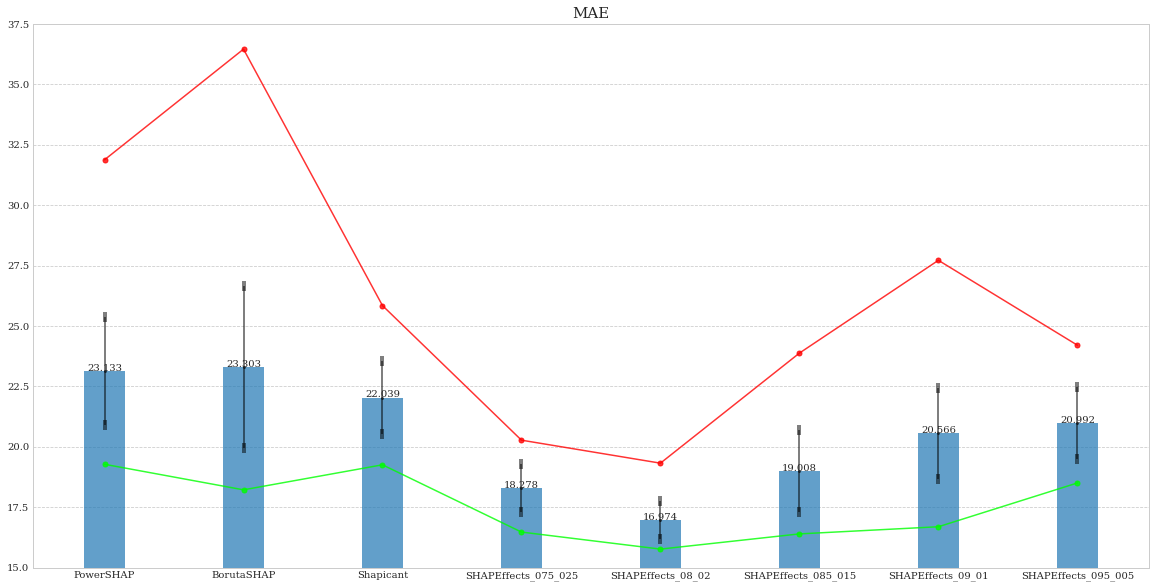

In [87]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_mae_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_mae_mean, resultados_mae_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_mae_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_mae_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("MAE")
ax.title.set_size(15)
for index,data in enumerate(resultados_mae_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([15, 37.5])


## RMSE

In [80]:
resultados_rmse_mean = [mean_powershap_test['rmse'], mean_borutashap_test['rmse'], mean_shapicant_test['rmse'], mean_shapeffects_075_025_test['rmse'], mean_shapeffects_08_02_test['rmse'], mean_shapeffects_085_015_test['rmse'], mean_shapeffects_09_01_test['rmse'], mean_shapeffects_095_005_test['rmse']]
resultados_rmse_std = [std_powershap_test['rmse'], std_borutashap_test['rmse'], std_shapicant_test['rmse'], std_shapeffects_075_025_test['rmse'], std_shapeffects_08_02_test['rmse'], std_shapeffects_085_015_test['rmse'], std_shapeffects_09_01_test['rmse'], std_shapeffects_095_005_test['rmse']]
resultados_rmse_max = [max_powershap_test['rmse'], max_borutashap_test['rmse'], max_shapicant_test['rmse'], max_shapeffects_075_025_test['rmse'], max_shapeffects_08_02_test['rmse'], max_shapeffects_085_015_test['rmse'], max_shapeffects_09_01_test['rmse'], max_shapeffects_095_005_test['rmse']]
resultados_rmse_min = [min_powershap_test['rmse'], min_borutashap_test['rmse'], min_shapicant_test['rmse'], min_shapeffects_075_025_test['rmse'], min_shapeffects_08_02_test['rmse'], min_shapeffects_085_015_test['rmse'], min_shapeffects_09_01_test['rmse'], min_shapeffects_095_005_test['rmse']]

(17.5, 42.5)

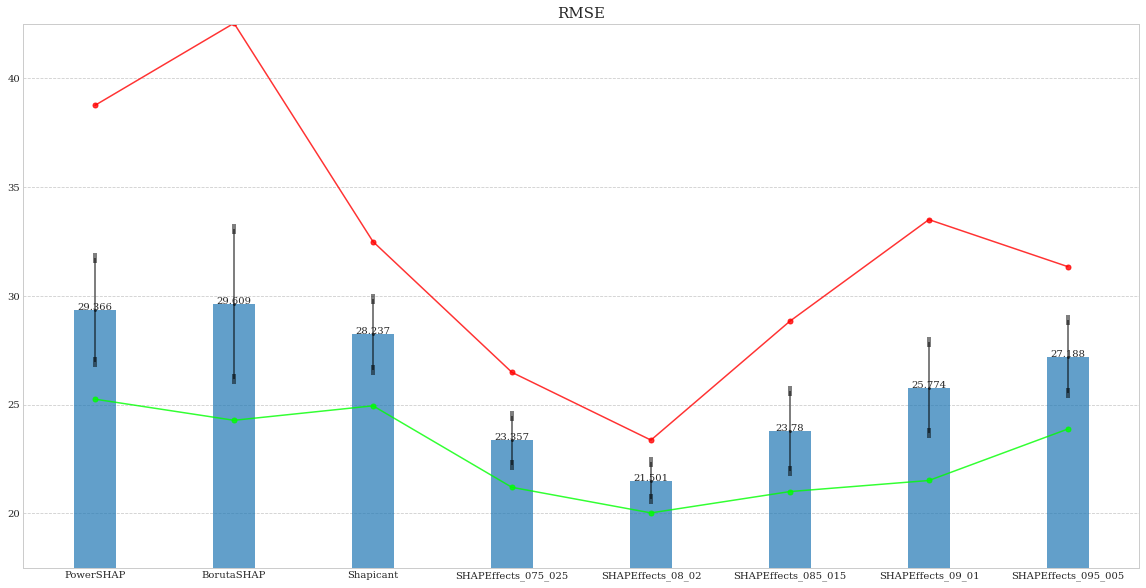

In [88]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_rmse_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_rmse_mean, resultados_rmse_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_rmse_max, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_rmse_min, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("RMSE")
ax.title.set_size(15)
for index,data in enumerate(resultados_rmse_mean):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([17.5, 42.5])

## R2

In [82]:
resultados_r2_mean = [mean_powershap_test['r2'], mean_borutashap_test['r2'], mean_shapicant_test['r2'], mean_shapeffects_075_025_test['r2'], mean_shapeffects_08_02_test['r2'], mean_shapeffects_085_015_test['r2'], mean_shapeffects_09_01_test['r2'], mean_shapeffects_095_005_test['r2']]
resultados_r2_std = [std_powershap_test['r2'], std_borutashap_test['r2'], std_shapicant_test['r2'], std_shapeffects_075_025_test['r2'], std_shapeffects_08_02_test['r2'], std_shapeffects_085_015_test['r2'], std_shapeffects_09_01_test['r2'], std_shapeffects_095_005_test['r2']]
resultados_r2_max = [max_powershap_test['r2'], max_borutashap_test['r2'], max_shapicant_test['r2'], max_shapeffects_075_025_test['r2'], max_shapeffects_08_02_test['r2'], max_shapeffects_085_015_test['r2'], max_shapeffects_09_01_test['r2'], max_shapeffects_095_005_test['r2']]
resultados_r2_min = [min_powershap_test['r2'], min_borutashap_test['r2'], min_shapicant_test['r2'], min_shapeffects_075_025_test['r2'], min_shapeffects_08_02_test['r2'], min_shapeffects_085_015_test['r2'], min_shapeffects_09_01_test['r2'], min_shapeffects_095_005_test['r2']]

In [83]:
resultados_r2_max, resultados_r2_min

([0.33423349340719566,
  0.3845210415529694,
  0.35026020822394033,
  0.5309263160018031,
  0.5815361040370997,
  0.5394916413963877,
  0.5168724431009781,
  0.4046497727829732],
 [-0.5692391371643712,
  -0.8898485640650342,
  -0.10286121639244605,
  0.2676518359820558,
  0.4298262571045006,
  0.13161560764633595,
  -0.17253411947155595,
  -0.02593285543308843])

(-1.0, 0.7)

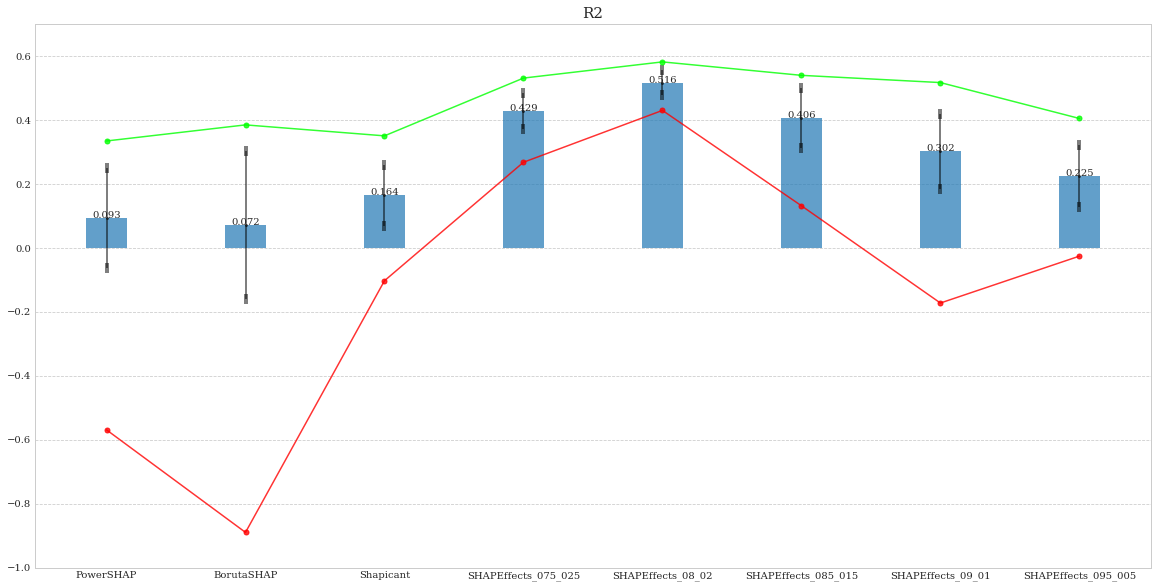

In [90]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
ax.bar(nombres, resultados_r2_mean, alpha = 0.7, width=0.3)
ax.errorbar(nombres, resultados_r2_mean, resultados_r2_std, fmt='.', color='Black', elinewidth=2,capthick=10,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax.plot(nombres, resultados_r2_max, color='lime', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.plot(nombres, resultados_r2_min, color='red', alpha=0.8, linestyle='-', marker='.', markersize=10)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("R2")
ax.title.set_size(15)
for index,data in enumerate(resultados_r2_mean):
    ax.text(x=index , y =data+0.001 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([-1, 0.7])

## Number of variables

In [85]:
n_var = [len(selected_features_powershap), len(selected_features_borutashap), len(selected_features_shapicant), len(selected_features_shapeffects_075_025), len(selected_features_shapeffects_08_02), len(selected_features_shapeffects_085_015), len(selected_features_shapeffects_09_01), len(selected_features_shapeffects_095_005)]

(0.0, 150.0)

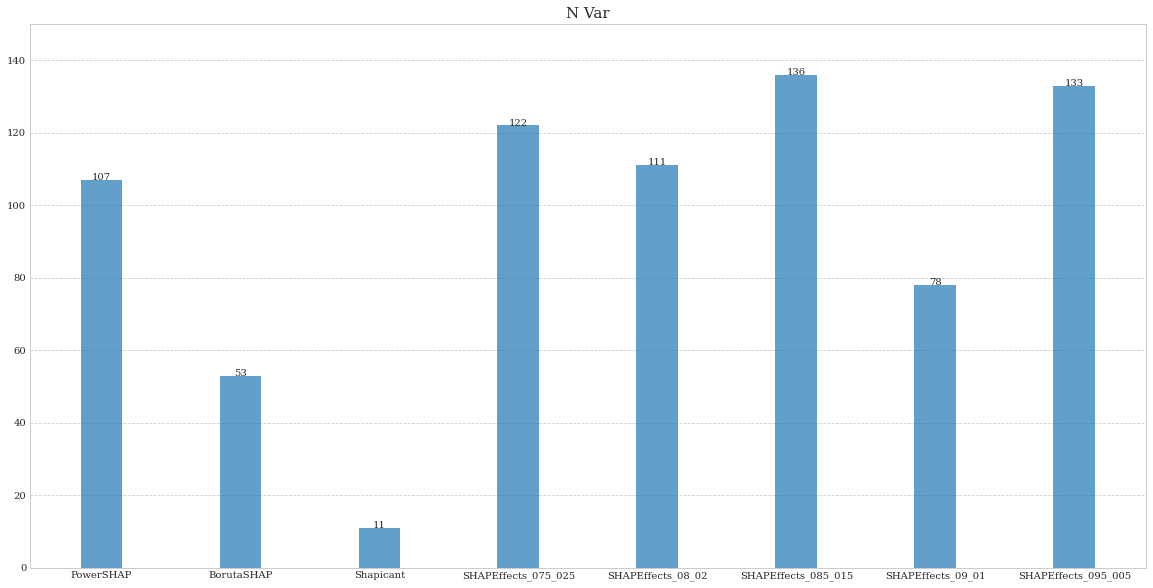

In [86]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
bars = ax.bar(nombres, n_var, alpha = 0.7, width=0.3)
ax.yaxis.grid(True,linestyle='--')
ax.xaxis.grid(False)
ax.title.set_text("N Var")
ax.title.set_size(15)
for index,data in enumerate(n_var):
    ax.text(x=index , y =data+0.01 , s=f"{round(data, 3)}" , fontdict=dict(fontsize=10), ha='center')
ax.set_ylim([0, 150])